# MXNet Model Exporting to ONNX Format

In [1]:
import os
import numpy as np
import IPython.display
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import onnx
from onnx import checker

import onnxruntime as rt

import mxnet as mx
from mxnet import gluon
from mxnet import nd
from mxnet.gluon.model_zoo import vision
from mxnet.contrib import onnx as onnx_mxnet

## Download the model

In [2]:
model_name = 'alexnet'
#model_name = 'resnet18_v1'
#model_name = 'mobilenetv2_1.0'

In [3]:
net = vision.get_model(model_name, pretrained=True)

In [4]:
print(net)

AlexNet(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), Activation(relu))
    (1): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (2): Conv2D(64 -> 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), Activation(relu))
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (4): Conv2D(192 -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (5): Conv2D(384 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (6): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (7): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (8): Flatten
    (9): Dense(9216 -> 4096, Activation(relu))
    (10): Dropout(p = 0.5, axes

## Do inference with MXNet

### Prepare test source image

In [5]:
def center_crop(img, width, height):
    src_width, src_height = img.size
    left = (src_width - width) // 2
    upper = (src_height - height) // 2
    right = left + width
    lower = upper + height
    img = img.crop((left, upper, right, lower))
    return img

In [6]:
def preprocess_imagenet(image):
    short = min(image.size)
    image = center_crop(image, short, short)
    image = image.resize((224, 224), resample=Image.BICUBIC)
    image = np.array(image, dtype=np.float32)
    image /= 255.0
    image -= [0.485, 0.456, 0.406]
    image /= [0.229, 0.224, 0.225]
    image = np.clip(image, 0, 1)
    return image

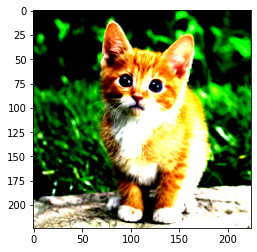

(224, 224, 3)


In [7]:
img_path = gluon.utils.download('https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/python/predict_image/cat.jpg')
img = Image.open(img_path)
img = preprocess_imagenet(img)
plt.imshow(img)
plt.show()
print(img.shape)

### Load labels

In [8]:
lbl_path = gluon.utils.download('http://data.mxnet.io/models/imagenet/synset.txt')
with open(lbl_path, 'r') as f:
    labels = [l.rstrip() for l in f]

### Do inference

In [9]:
# set context
ctx = mx.cpu()

# load pre-trained model
net.hybridize(static_alloc=True, static_shape=True)

img = nd.array(img)
img = img.transpose((2, 0, 1))
img = img.expand_dims(axis=0) # batchify
img = img.as_in_context(ctx)

prob = net(img).softmax() # predict and normalize output

idx = prob.topk(k=5)[0] # get top 5 result
for i in idx:
    i = int(i.asscalar())
    print('With prob = %.5f, it contains %s' % (prob[0,i].asscalar(), labels[i]))

With prob = 0.43931, it contains n02123159 tiger cat
With prob = 0.24558, it contains n02124075 Egyptian cat
With prob = 0.18962, it contains n02123045 tabby, tabby cat
With prob = 0.03113, it contains n02127052 lynx, catamount
With prob = 0.01824, it contains n02909870 bucket, pail


## Export to ONNX format

### Save the MXNet model

In [10]:
net.export(model_name)

In [11]:
sym = model_name + '-symbol.json'
params = model_name + '-0000.params'

In [12]:
# Path of the output file
onnx_file = model_name + '.onnx'

### MXNet model -> ONNX model

In [13]:
# Standard Imagenet input - 3 channels, 224*224
input_shape = (1,3,224,224)

# Invoke export model API. It returns path of the converted onnx model
converted_model_path = onnx_mxnet.export_model(sym, params, [input_shape], np.float32, onnx_file)

In [14]:
print(converted_model_path)

alexnet.onnx


### Check the exported ONNX model

In [15]:
# Load onnx model
model_proto = onnx.load_model(converted_model_path)

# Check if converted ONNX protobuf is valid
checker.check_graph(model_proto.graph)

## Visualize the model 

In [16]:
os.environ['ONNX_PATH'] = onnx.__path__[0]
os.environ['MODEL_NAME'] = model_name

In [17]:
!python3 ${ONNX_PATH}/tools/net_drawer.py --input ${MODEL_NAME}.onnx --output ${MODEL_NAME}.dot

In [18]:
!dot -Tpng -Grankdir=TB ${MODEL_NAME}.dot > ${MODEL_NAME}.png

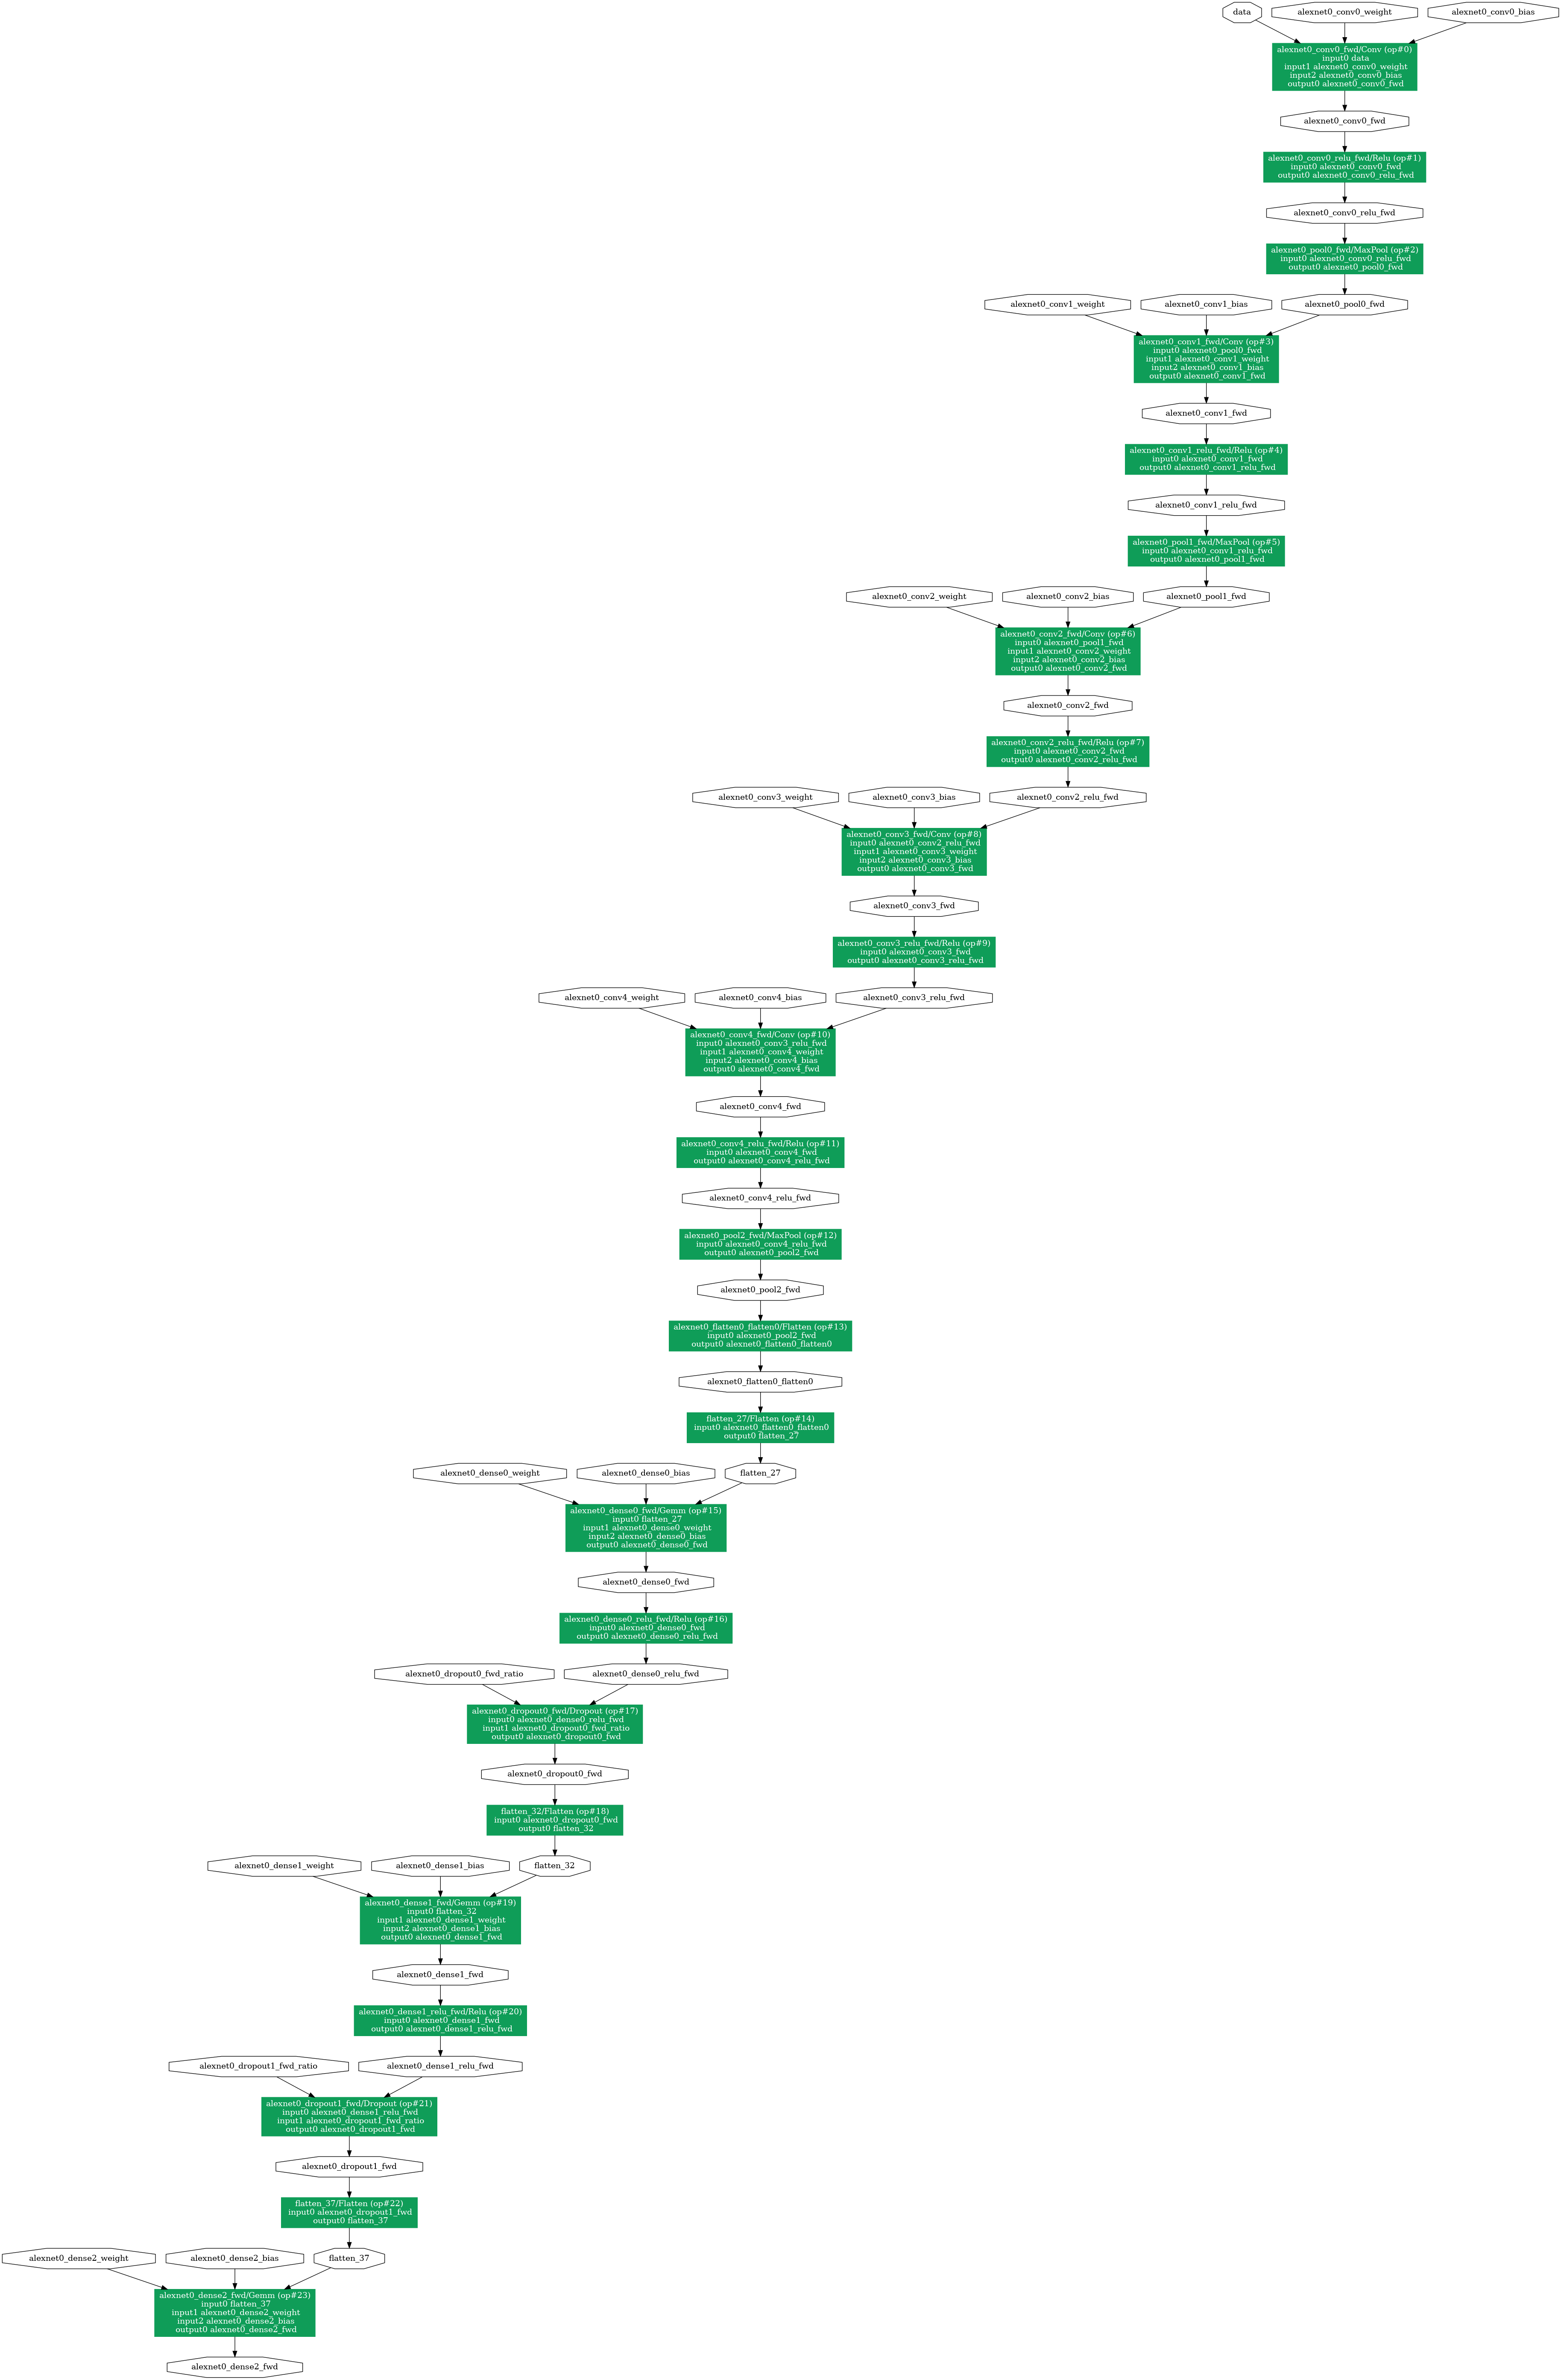

In [19]:
IPython.display.Image(model_name + '.png')

## Do inference with ONNXRuntime

In [20]:
img_np = img.asnumpy()
print(type(img_np))
print(type(img_np[0][0][0][0]))
print(img_np.shape)
with open('img.npy', 'wb') as f:
    np.save(f, img_np)

<class 'numpy.ndarray'>
<class 'numpy.float32'>
(1, 3, 224, 224)


In [21]:
sess = rt.InferenceSession(model_name + '.onnx')
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

2021-11-19 05:06:03.466713907 [W:onnxruntime:, graph.cc:1137 Graph] Initializer alexnet0_conv0_weight appears in graph inputs and will not be treated as constant value/weight. This may prevent some of the graph optimizations, like const folding. Move it out of graph inputs if there is no need to override it, by either re-generating the model with latest exporter/converter or with the tool onnxruntime/tools/python/remove_initializer_from_input.py.
2021-11-19 05:06:03.466742678 [W:onnxruntime:, graph.cc:1137 Graph] Initializer alexnet0_conv0_bias appears in graph inputs and will not be treated as constant value/weight. This may prevent some of the graph optimizations, like const folding. Move it out of graph inputs if there is no need to override it, by either re-generating the model with latest exporter/converter or with the tool onnxruntime/tools/python/remove_initializer_from_input.py.
2021-11-19 05:06:03.466747232 [W:onnxruntime:, graph.cc:1137 Graph] Initializer alexnet0_conv1_weigh

In [22]:
pred_onnx = sess.run(
    [output_name], {input_name: img_np})[0][0]

In [23]:
pred_onnx = np.exp(pred_onnx)/sum(np.exp(pred_onnx))

In [24]:
idxlist = np.argsort(pred_onnx)[:-6:-1]
for i in idxlist:
    print('{}:\t{}'.format(labels[i], pred_onnx[i]))

n02123159 tiger cat:	0.4393051564693451
n02124075 Egyptian cat:	0.24557553231716156
n02123045 tabby, tabby cat:	0.18962442874908447
n02127052 lynx, catamount:	0.03113098070025444
n02909870 bucket, pail:	0.018238741904497147
